In [1]:
%matplotlib inline


# Generation of stochastic noise

This example script shows how to run the stochastic noise field generators
included in pysteps.

These noise fields are used as perturbation terms during an extrapolation
nowcast in order to represent the uncertainty in the evolution of the rainfall
field.


In [2]:
from matplotlib import cm, pyplot as plt
import numpy as np
import os
from pprint import pprint
from pysteps import io, rcparams
from pysteps.noise.fftgenerators import initialize_param_2d_fft_filter
from pysteps.noise.fftgenerators import initialize_nonparam_2d_fft_filter
from pysteps.noise.fftgenerators import generate_noise_2d_fft_filter
from pysteps.utils import conversion, rapsd, transformation
from pysteps.visualization import plot_precip_field, plot_spectrum1d

Pysteps configuration file found at: /home/runner/.pysteps/pystepsrc



## Read precipitation field

First thing,  the radar composite is imported and transformed in units
of dB.
This image will be used to train the Fourier filters that are necessary to
produce the fields of spatially correlated noise.



{'accutime': 5.0,
 'cartesian_unit': 'm',
 'institution': 'MeteoSwiss',
 'product': 'AQC',
 'projection': '+proj=somerc  +lon_0=7.43958333333333 +lat_0=46.9524055555556 '
               '+k_0=1 +x_0=600000 +y_0=200000 +ellps=bessel '
               '+towgs84=674.374,15.056,405.346,0,0,0,0 +units=m +no_defs',
 'threshold': 0.01155375598376629,
 'transform': None,
 'unit': 'mm/h',
 'x1': 255000.0,
 'x2': 965000.0,
 'xpixelsize': 1000.0,
 'y1': -160000.0,
 'y2': 480000.0,
 'yorigin': 'upper',
 'ypixelsize': 1000.0,
 'zerovalue': 0.0,
 'zr_a': 316.0,
 'zr_b': 1.5}


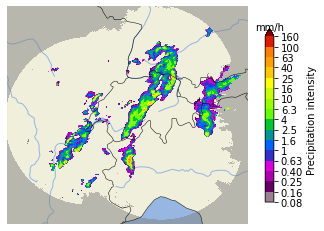

In [3]:
# Import the example radar composite
root_path = rcparams.data_sources["mch"]["root_path"]
filename = os.path.join(root_path, "20160711", "AQC161932100V_00005.801.gif")
R, _, metadata = io.import_mch_gif(filename, product="AQC", unit="mm", accutime=5.0)

# Convert to mm/h
R, metadata = conversion.to_rainrate(R, metadata)

# Nicely print the metadata
pprint(metadata)

# Plot the rainfall field
plot_precip_field(R, geodata=metadata)
plt.show()

# Log-transform the data
R, metadata = transformation.dB_transform(R, metadata, threshold=0.1, zerovalue=-15.0)

# Assign the fill value to all the Nans
R[~np.isfinite(R)] = metadata["zerovalue"]

## Parametric filter

In the parametric approach, a power-law model is used to approximate the power
spectral density (PSD) of a given rainfall field.

The parametric model uses  a  piece-wise  linear  function  with  two  spectral
slopes (beta1 and beta2) and one breaking point



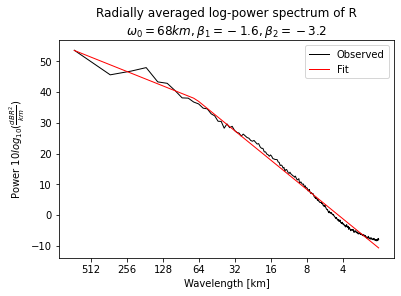

In [4]:
# Fit the parametric PSD to the observation
Fp = initialize_param_2d_fft_filter(R)

# Compute the observed and fitted 1D PSD
L = np.max(Fp["input_shape"])
if L % 2 == 1:
    wn = np.arange(0, int(L / 2) + 1)
else:
    wn = np.arange(0, int(L / 2))
R_, freq = rapsd(R, fft_method=np.fft, return_freq=True)
f = np.exp(Fp["model"](np.log(wn), *Fp["pars"]))

# Extract the scaling break in km, beta1 and beta2
w0 = L / np.exp(Fp["pars"][0])
b1 = Fp["pars"][2]
b2 = Fp["pars"][3]

# Plot the observed power spectrum and the model
fig, ax = plt.subplots()
plot_scales = [512, 256, 128, 64, 32, 16, 8, 4]
plot_spectrum1d(
    freq,
    R_,
    x_units="km",
    y_units="dBR",
    color="k",
    ax=ax,
    label="Observed",
    wavelength_ticks=plot_scales,
)
plot_spectrum1d(
    freq,
    f,
    x_units="km",
    y_units="dBR",
    color="r",
    ax=ax,
    label="Fit",
    wavelength_ticks=plot_scales,
)
plt.legend()
ax.set_title(
    "Radially averaged log-power spectrum of R\n"
    r"$\omega_0=%.0f km, \beta_1=%.1f, \beta_2=%.1f$" % (w0, b1, b2)
)
plt.show()

## Nonparametric filter

In the nonparametric approach,  the Fourier filter is obtained directly
from the power spectrum of the observed precipitation field R.



In [5]:
Fnp = initialize_nonparam_2d_fft_filter(R)

## Noise generator

The parametric and nonparametric filters obtained above can now be used
to produce N realizations of random fields of prescribed power spectrum,
hence with the same correlation structure as the initial rainfall field.



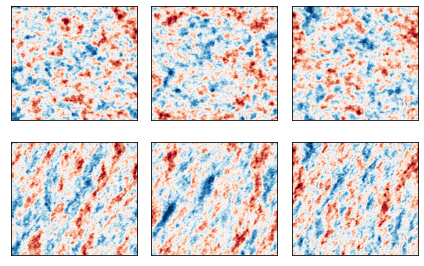

In [6]:
seed = 42
num_realizations = 3

# Generate noise
Np = []
Nnp = []
for k in range(num_realizations):
    Np.append(generate_noise_2d_fft_filter(Fp, seed=seed + k))
    Nnp.append(generate_noise_2d_fft_filter(Fnp, seed=seed + k))

# Plot the generated noise fields

fig, ax = plt.subplots(nrows=2, ncols=3)

# parametric noise
ax[0, 0].imshow(Np[0], cmap=cm.RdBu_r, vmin=-3, vmax=3)
ax[0, 1].imshow(Np[1], cmap=cm.RdBu_r, vmin=-3, vmax=3)
ax[0, 2].imshow(Np[2], cmap=cm.RdBu_r, vmin=-3, vmax=3)

# nonparametric noise
ax[1, 0].imshow(Nnp[0], cmap=cm.RdBu_r, vmin=-3, vmax=3)
ax[1, 1].imshow(Nnp[1], cmap=cm.RdBu_r, vmin=-3, vmax=3)
ax[1, 2].imshow(Nnp[2], cmap=cm.RdBu_r, vmin=-3, vmax=3)

for i in range(2):
    for j in range(3):
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
plt.tight_layout()
plt.show()

The above figure highlights the main limitation of the parametric approach
(top row), that is, the assumption of an isotropic power law scaling
relationship, meaning that anisotropic structures such as rainfall bands
cannot be represented.

Instead, the nonparametric approach (bottom row) allows generating
perturbation fields with anisotropic  structures, but it also requires a
larger sample size and is sensitive to the quality of the input data, e.g.
the presence of residual clutter in the radar image.

In addition, both techniques assume spatial stationarity of the covariance
structure of the field.



In [7]:
# sphinx_gallery_thumbnail_number = 3